# Анализ поведения пользователей в приложении по продаже продуктов. 

## Введение

Цель: 
- для приложения по продаже продуктов питания определить пользовательское поведение
- определить влияние изменения шрифта в приложении на изменение поведения пользователей

План:
- провести выгрузку и предобработку данных
- изучить и проверить данные
- изучить воронку событий
- оценить результаты эксперимента

## Выгрузка и предобработка данных 

In [1]:
# импортирую необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings; warnings.filterwarnings(action = 'ignore') 
from plotly import graph_objects as go
from matplotlib.ticker import MultipleLocator


In [2]:
pd.set_option('display.max_colwidth', False)

In [3]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')


In [4]:
#посмотрю общую информацию о таблице
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
print('Пропуски', data.isna().sum())

Пропуски EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


In [6]:
print('Количество дубликатов:', data.duplicated().sum())
print('Доля дубликатов:',data.duplicated().sum() / len(data))

Количество дубликатов: 413
Доля дубликатов: 0.0016917493425526163


Я импортировала необходимые библиотеки, выгрузила датасет /datasets/logs_exp.csv' и провела первичный обзор данных.

Обнаружила 413 дубликатов, 0 пропусков и не подходящий формат данных в EventTimestamp 

### Предобработка данных

Проведу предобработку данных

In [7]:
#посмотрю названия столбцов 
#data.columns.to_list()

In [8]:
#приведу названия столбцов к "хорошему тону"

#data.columns = ['event', 'user_id', 'date_time', 'group_id']
#data.head()

In [9]:
data = data.rename(columns={'EventName': 'event', 'DeviceIDHash': 'user_id', 
                            'EventTimestamp': 'date_time', 'ExpId': 'group_id'})

In [10]:
# изменю формат данных в солбце date_time
data['date_time'] = pd.to_datetime(data['date_time'], unit='s')

# добавим поле с датой:

data['date'] = pd.to_datetime(data['date_time'].dt.date)
data.head(1)

,event,user_id,date_time,group_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25


In [11]:
#удалю дубликаты их доля менее 1%
data = data.drop_duplicates().reset_index(drop=True)


In [12]:
#на всякий проверю нет ли пользовтелей, которы попали в несколько групп
data.groupby('user_id')['group_id'].nunique().reset_index().query('group_id > 1')

,user_id,group_id


На данном этапе я провела предобработку данных:
- привела названия столбцов к "хорошему тону"
- изменила тип данных в столбце date_time
- удалила дубликаты
- добавила столбец, который потребуется для дальнейших расчетов
- пользователей, которые оказались в разных группах нет

## Изучение и проверка данных

In [13]:
#Посмотрю сколько всего событий в логе
print('Всего событий:',data.shape[0])

Всего событий: 243713


In [14]:
 #Посмотрю сколько всего пользователей в логе
print('Всего пользователей:', data['user_id'].nunique())

Всего пользователей: 7551


In [15]:
#Посмотрю сколько в среднем событий приходится на пользователя
print('В среднем, событий на пользователя:', data.shape[0] / data['user_id'].nunique())

В среднем, событий на пользователя: 32.27559263673685


count    7551.000000
mean     32.275593  
std      65.154219  
min      1.000000   
25%      9.000000   
50%      20.000000  
75%      37.000000  
max      2307.000000
Name: event_count, dtype: float64

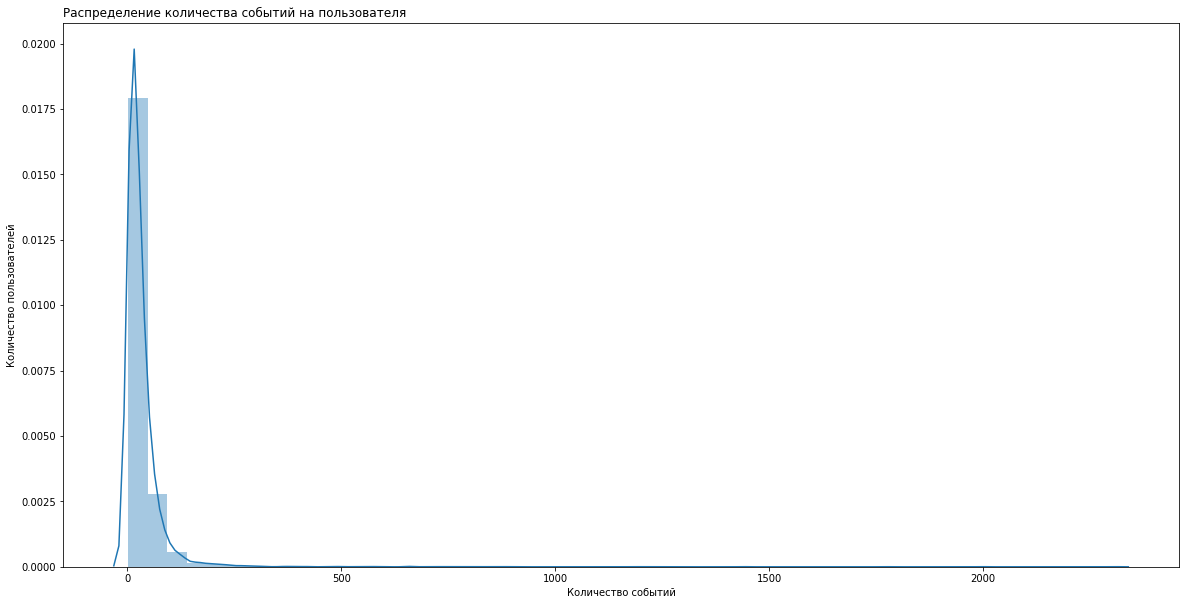

In [16]:
# гистограмма
event_users = data.groupby('user_id').agg(event_count = ('event', 'count')).reset_index()

display(event_users['event_count'].describe()) 

plt.figure(figsize=(20, 10))
plt.title('Распределение количества событий на пользователя', loc='left')
sns.distplot(event_users['event_count'], bins=50)
plt.xlabel('Количество событий')                  
plt.ylabel('Количество пользователей')             
plt.show()

Всего действий 7551, среднее количество 32. Минимальное - 1 действие. Максимальное - 2307. Кажется, что 2307 может искажать среднее.
Медианное кол-во событий - 20. Думаю, что правильнее рассмотреть медианное кол-во действий 


#### Посмотрю, какой период данных у меня есть

- Найду максимальную и минимальную дату. 
- Построю гистограмму по дате и времени. 


In [17]:
#дата начала и конца теста
print('Минимальная дата', min(data['date_time']))
print('Максимальная дата', max(data['date_time']))

Минимальная дата 2019-07-25 04:43:36
Максимальная дата 2019-08-07 21:15:17


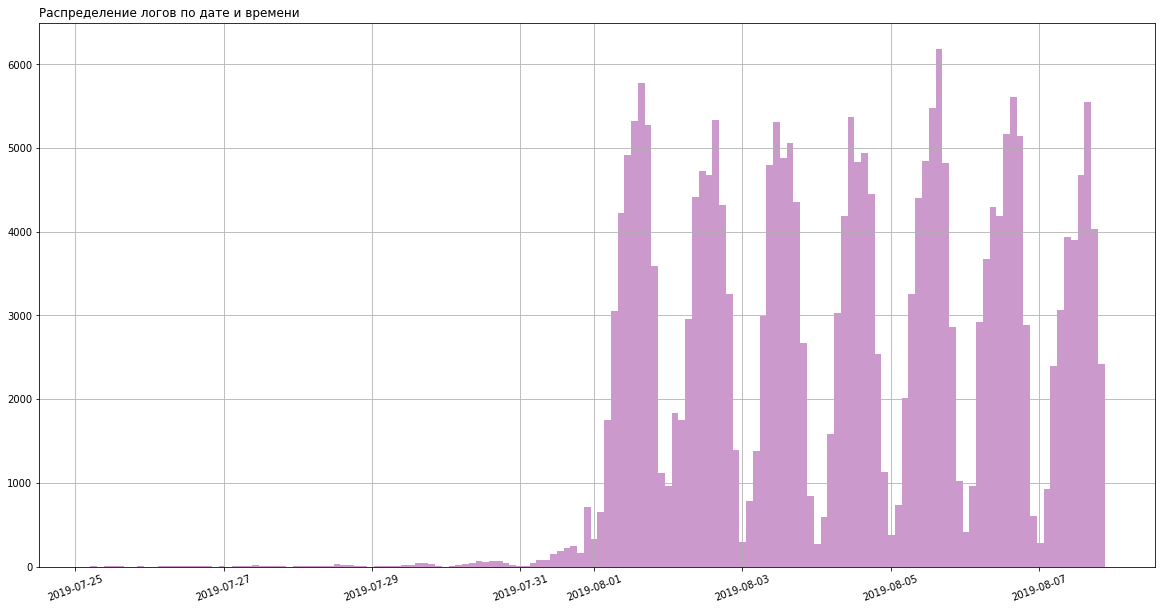

In [18]:
# гистограммы по дате и времени:

plt.title('Распределение логов по дате и времени', loc='left')
data['date_time'].hist(bins=150, xrot=20, figsize=(20, 10),color='purple', alpha=0.4)
plt.show()


Вижу по графику, что данных с 25.07 по 31.07 сильно меньше или они отсутствуют. Рост начинается с 1.08. Полагаю, что это свзяано с техническими особенностями, так как технически в логи новых дней по некоторым пользователям могут догружаться события из прошлого — это может искажать данные.

Предлагаю использовать данные с  1.08.19 по 7.08.19. 

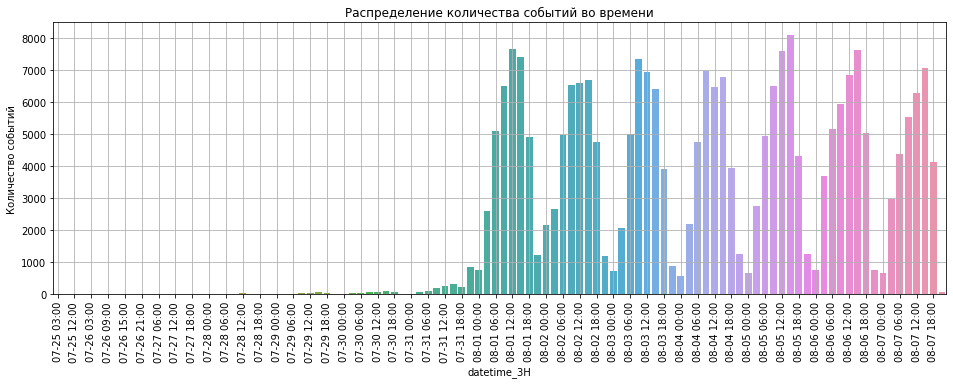

In [19]:
fig, axes = plt.subplots (1, 1, figsize= (16, 5))

data_for_plot = (data.assign(datetime_3H = lambda x: x['date_time'].dt.floor ('3H').dt.strftime ('%m-%d %H:%M')).groupby('datetime_3H').agg({'event':'count'}). reset_index())


sns.barplot (x= 'datetime_3H', y= 'event',  data=data_for_plot, ci = None)
axes.set_title("Распределение количества событий во времени")
axes.set_ylabel ('Количество событий')
axes.grid(which='both', )
axes.tick_params(axis='x', labelrotation =90)
axes.xaxis.set_major_locator (locator=MultipleLocator (2))
plt.show()

Все так же вижу по графику, что данных с 25.07 по 31.07 сильно меньше или они отсутствуют. Рост начинается с 00:00 1.08. 

К выводу можно добавить, что основная активность пользователей приходится на дневное время.

Предлагаю использовать данные с  1.08.19 по 7.08.19. 

Отброшу данные до 1.08.19. 


Посмотрю, сколько событий и пользователей потерялось при удалении данных до 1.08.19

In [20]:
#посмотрю количество логов и пользователей до удаления
old_logs = data.shape[0]
old_users = data['user_id'].nunique()

print('События до корректировки:', old_logs)
                                                                           
print('Всего пользователей',old_users)

#исключу данные до 1.08.2019
data = data[data['date_time'] > '2019-08-01']
print()

#посмотрю количество логов и пользователей после удаления
print('События после корректировки:', data.shape[0]) 
print('Всего пользователей:',data['user_id'].nunique())
print()

События до корректировки: 243713
Всего пользователей 7551

События после корректировки: 240887
Всего пользователей: 7534



In [21]:
#посчитаю дельту по событиям и пользователям
print('Дельта событий:',data.shape[0]- old_logs,'({:.1%})'.format((data.shape[0]-old_logs)/old_logs))
print('Дельта количества юзеров:',data['user_id'].nunique()- old_users,'({:.1%})'.format((data['user_id'].nunique()-old_users)/old_users))

Дельта событий: -2826 (-1.2%)
Дельта количества юзеров: -17 (-0.2%)


 Отброшено: 
 - 2826 событий(1,2%)
 - 17 пользователей (0,2%)

#### Посмотрю, что есть пользователи из всех трёх экспериментальных групп.

In [22]:
data.groupby('group_id').agg({'user_id': 'count'}).rename(columns={'user_id' : 'count_users'})

,count_users
group_id,
246,79302
247,77022
248,84563


- В группе 248 - 84 563 пользователя
- В группе 247 - 77 022 пользователя
- В группе 246 - 79 302 пользователя


В целом количество пользователей в одном диапазоне

## Изучение воронки событий

In [23]:
#Посмотрю, какие события есть в логах и как часто они встречаются
events = (data.groupby('event').agg({'user_id': 'count'}).reset_index().rename(columns={'user_id' : 'total_events'}).sort_values(by='total_events', ascending=False))
events

,event,total_events
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


- Больше всего событий MainScreenAppear (появление главного экрана)
- Меньше всего событий Tutorial (руководство)

In [24]:
#Посчитаю, сколько пользователей совершали каждое из этих событий

user_ev = (data.groupby('event').agg({'user_id': 'nunique'}).reset_index().rename(columns={'user_id' : 'total_users'}).sort_values(by='total_users', ascending=False))

user_ev['percent'] = user_ev['total_users'] / data['user_id'].nunique() * 100 
user_ev

,event,total_users,percent
1,MainScreenAppear,7419,98.473586
2,OffersScreenAppear,4593,60.963632
0,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


Открыли главный экран 7419 пользователей (98,5%). Экран предложений открыли 4593 пользователей (61%). Корзину открыли 3734 (49,6%). До экрана оплаты дошли 3539 (47%). Туториал-инструктаж открыли 840 пользователй (11,1%)

*Предположу такой порядок событий:*

MainScreenAppear - появление главного экрана -> OffersScreenAppear - появление экрана предложений -> CartScreenAppear - появление экрана корзины -> PaymentScreenSuccessful - экран успешной оплаты 

Tutorial в цепочку не встраивается. Это событие не приводит к покупке, предлагаю исключить его из расчета воронки.

#### Определю долю пользователей на каждом этапе воронки

In [25]:
user_ev = user_ev[user_ev['event'] != 'Tutorial']
user_ev


,event,total_users,percent
1,MainScreenAppear,7419,98.473586
2,OffersScreenAppear,4593,60.963632
0,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719


Больше всего пользователей на этапе MainScreenAppear (появление главного экрана) - 98,5%

In [26]:
#посмотрю, на каком шаге теряется больше всего пользователей

print('Доля, открывших каталог:', ((4593/7419)*100))
print('Доля, открывших корзину:', ((3734/4593)*100))
print('Доля, открывших страницу оплаты:', ((3539/3734)*100))
print()
print('Потерянные с главного в каталог:', (100-(4593/7419)*100))
print('Потерянные из каталога в корзину:', ((3734/4593)*100)-(4593/7419)*100)
print('Потерянные из корзины на экран оплаты:', ((3539/3734)*100)-(3734/4593)*100)






Доля, открывших каталог: 61.908613020622724
Доля, открывших корзину: 81.29762682342695
Доля, открывших страницу оплаты: 94.7777182645956

Потерянные с главного в каталог: 38.091386979377276
Потерянные из каталога в корзину: 19.38901380280423
Потерянные из корзины на экран оплаты: 13.480091441168653


Больше всего пользователей (примерно 38%) теряется на шаге перехода с главного экрана на страницк предложений

In [27]:
#посмотрю долю пользователей, которая доходит от первого события до оплаты
print('Доля пользователей,которые дошли до оплаты с первого события:', ((3539/7419)*100))

Доля пользователей,которые дошли до оплаты с первого события: 47.70184661005526


In [28]:
#посмотрю, на каком шаге теряется больше всего пользователей

users = data.pivot_table(index='user_id',columns='event',values='date_time',aggfunc='min')

print('Пользователей всего:', 
      '({:.1%})'.format(users['MainScreenAppear'].count() / users['MainScreenAppear'].count() ))
print('Доля, открывших каталог:', 
      '({:.1%})'.format(users['OffersScreenAppear'].count() / users['MainScreenAppear'].count() ))
print('Доля, открывших корзину:', 
      '({:.1%})'.format(users['CartScreenAppear'].count() / users['OffersScreenAppear'].count()))
print('Доля, открывших страницу оплаты:',
      '({:.1%})'.format(users['PaymentScreenSuccessful'].count() / users['CartScreenAppear'].count()))

Пользователей всего: (100.0%)
Доля, открывших каталог: (61.9%)
Доля, открывших корзину: (81.3%)
Доля, открывших страницу оплаты: (94.8%)


In [29]:
print('Потерянные с главного в каталог:', 
      '({:.1%})'.format(1-(users['OffersScreenAppear'].count() / users['MainScreenAppear'].count())))

print('Потерянные из каталога в корзину:', 
      '({:.1%})'.format((users['CartScreenAppear'].count() / users['OffersScreenAppear'].count())-(users['OffersScreenAppear'].count()/users['MainScreenAppear'].count())))

print('Потерянные из корзины на экран оплаты:', 
      '({:.1%})'.format((users['PaymentScreenSuccessful'].count() / users['CartScreenAppear'].count())-(users['CartScreenAppear'].count()/users['OffersScreenAppear'].count())))

Потерянные с главного в каталог: (38.1%)
Потерянные из каталога в корзину: (19.4%)
Потерянные из корзины на экран оплаты: (13.5%)


In [30]:
print('Доля пользователей,которые дошли до оплаты с первого события:','({:.1%})'.format(users['PaymentScreenSuccessful'].count() / users['MainScreenAppear'].count()))

Доля пользователей,которые дошли до оплаты с первого события: (47.7%)


## Изучение результатов эксперимента по изменению шрифта

Известно, что 246 и 247 — контрольные группы(А/А), а 248 — экспериментальная (В).

Посмотрю, сколько пользователей в каждой  группе.

In [31]:
data.groupby('group_id').agg(count=('user_id', 'nunique'))

,count
group_id,
246,2484
247,2513
248,2537


In [32]:
user_group = (data.groupby(['event', 'group_id']).agg({'user_id': 'nunique'}).reset_index().rename(columns={'user_id' : 'total_users'}).sort_values(by=['group_id','total_users'], ascending=False))

user_group = user_group[user_group['event'] != 'Tutorial']
user_group

,event,group_id,total_users
5,MainScreenAppear,248,2493
8,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
11,PaymentScreenSuccessful,248,1181
4,MainScreenAppear,247,2476
7,OffersScreenAppear,247,1520
1,CartScreenAppear,247,1238
10,PaymentScreenSuccessful,247,1158
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542


Количество пользователей на каждом шаге по группам примерно одинаковое.

По условию заказчика нужно сопоставить доли по каждому событию:

- между группами 246 и 247
- каждой из контрольной группы по отдельности и экспериментальной (246 и 248; 247 и 248)
- объединенной контрольной группой и экспериментальной (сумма событий 246 и 247; и 248)

Для проверки гипотез для долей буду использовать z-test 



*Гипотезы:*

- Ho: Доля пользователей не отличается
- H1: Доля пользователей отличается

*Событий 4:*

- MainScreenAppear - появление главного экрана -> 
- OffersScreenAppear - появление экрана предложений -> 
- CartScreenAppear - появление экрана корзины -> 
- PaymentScreenSuccessful - экран успешной оплаты

In [33]:
#функция 
def z_test(t1, t2, event, alpha, n):
    
    
#уровень стат значимости с поправкой бонферрони.
#поправка бонферрони,так как можно поделить принятый уровень значимости на число сравнений, которые проведем на одних и тех же данных, без необходимости сбора новых наблюдений для каждого теста
    
    bonf_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([t1['user_id'].nunique(),t2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([t1[t1['event'] == event]['user_id'].nunique(), t2[t2['event'] == event]['user_id'].nunique()])

    # доля успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # доля успехов в комбинированной группе (сумма событий 246 и247):
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница долей в датасетах
    difference = p1 - p2 

    #статистика
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    #стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    #тест двусторонний
    p_value = (1 - distr.cdf(abs(z_value))) * 2  
    
    print('Событие:', event)
    print('p-value: ', p_value)

    if p_value < bonf_alpha:
        print('Отвергаем нулевую гипотезу: доли отличаются')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются')

In [34]:
#статистически значимое отличие для событий для 246 и 247

for event in user_group['event'].unique():
    z_test(data[data['group_id'] == 246], data[data['group_id'] == 247], event,.05, 4)
    print()

Событие: MainScreenAppear
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: OffersScreenAppear
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: CartScreenAppear
p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: PaymentScreenSuccessful
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются



В А/А между группами 246 и 247 ни для какого события нет статистически значимого отличия и нет оснований считать, что доли отличаются.



In [35]:
#статистически значимое отличие для событий для 246 и 248

for event in user_group['event'].unique():
    z_test(data[data['group_id'] == 246], data[data['group_id'] == 248], event, .05, 12)
    print()

Событие: MainScreenAppear
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: OffersScreenAppear
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: CartScreenAppear
p-value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: PaymentScreenSuccessful
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются



Для групп 246 и 247 для всех событий нет основания считать, что доли отличаются


In [36]:
#статистически значимое отличие для событий для объединённой и 248 

for event in user_group['event'].unique():
    z_test(data[data['group_id'] != 248], data[data['group_id'] == 248], event,.05,12)
    print()

Событие: MainScreenAppear
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: OffersScreenAppear
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: CartScreenAppear
p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: PaymentScreenSuccessful
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются



Нет оснований считать, что доли отличаются для объединенной группы и 248


In [37]:
# проверим, есть ли статистически значимая разница между контрольными группами 247 и 248:

for event in user_group['event'].unique():
    z_test(data[data['group_id'] == 247], data[data['group_id'] == 248], event,.05, 12)
    print()

Событие: MainScreenAppear
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: OffersScreenAppear
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: CartScreenAppear
p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются

Событие: PaymentScreenSuccessful
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать,что доли отличаются



Нет оснований считать, что доли между группами 246 и 248 отличаются.

Можно сделать вывод, что изменения шрифта не отразилось на повдении юзеров

## Вывод

В этом исследовании я провела вывгрузку и предобработку данных, проанализировала поведение пользователей в приложении по продаже продуктов. Рассмотрела действия пользователей с 1.08 по 7.08.19.Оценила результаты A/A/B-эксперимента.

Обнаружила, что было совершено всего событий 240 887, 7534-и пользователей. В среднем 32 лога на пользователя.

Больше всего пользователей посетило главный экран приложения 7419. Меньше всего открыли Туториал 840.
До оплаты дошли 3539 юзеров (47%).

Существенная часть пользователей была потеряна на этапе перехода с главной страницы на страницу предложений - 38%


В эксперименте участвовало 3 группы: 246,247 и 248. По итогам эксперимента с изменением шрифта в приложении статистически значимого различия между группами не обнаружилось. Поэтому нельзя утверждать, что изменение шрифта в данном приложении повлияло на пользовательское поведение.


